# Counteracting Overfitting

Overfitting is the primary cause of model innacuracy. When a model is overfitted, it performs well when predicting the class of images on which it has been trained; but does not generalize well to new images.

## Techniques for Avoiding Overfitting

There are a number of ways to address overfitting during the training process. In this notebook, we'll look at two of the most common approaches.

### Dropping Feature Maps

The first approach is somewhat counter-intuitive, but very effective. During the training process, the convolution and pooling layers in the feature extraction section of the model generate lots of feature maps from the training images. Randomly dropping some of these feature maps helps vary the features that are extracted in each batch, ensuring the model doesn't become overly-reliant on any one dominant feature in the training data.

### Data Augmentation

In an ideal world, you'd have a huge volume of training data that is representative of all future data that you will submit to the model for inference. In reality, you must often traing a model with a limited set of training data, which can exacerbate the overfitting problem. One way to mitigate this is to perform data augmentation by making random transformations of the training images; for example by flipping, rotating, or cropping them. Because you randomly apply these data augmentation transformations during training, the same image might be presented differently from batch to batch, creating more variation in the training data and helping the model to learn features based the same objects at different orientations or scales.

## Adding Drop Layers and Data Augementation to a CNN

Let's take a look at using these techniques when training a PyTorch model. First, we'll import the latest version of PyTorch and prepare to load our training data.

> *Note: The following `pip install` commands install the CPU-based version of PyTorch on Linux, which is appropriate for the Azure Notebooks environment. For instructions on how to install the PyTorch and TorchVision packages on your own system, see https://pytorch.org/get-started/locally/*

In [1]:
# Install PyTorch
#!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)



Libraries imported - ready to use PyTorch 1.3.1


### Augment the Data
Now we're ready to define our data loaders. At this point we can add transformations to randomly modify the images as they are added to a training batch. In this case, we'll flip images horizontally at random.

In [2]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # Randomly augment the image data
        transforms.RandomHorizontalFlip(0.5),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader

import os

# The images are in a folder named 'shapes/training'
training_folder_name = '../data/shapes/training'

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(training_folder_name)
batch_size = train_loader.batch_size
print("Data loaders ready to read", training_folder_name)

['circle', 'square', 'triangle']
Data loaders ready to read ../data/shapes/training


### Add Drop Layers to the CNN
Now we're ready to define our model, which will include some drop layers to randomly drop some of the extracted features.

In [3]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
         # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 30% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.3)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
        
        # Use a relu activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.3, inplace=False)
  (fc): Linear(in_features=24576, out_features=3, bias=True)
)


### Train the Model

With the layers of the CNN defined, we're ready to train the model using our randomly augmented image data. Since we're dropping some features, it may require more epochs to get the loss to drop so that the model is reasonably accurate - but the data augmentation and dropped features should help ensure that as we train for more epochs, the validation loss drops along with the training loss; meaning that the model will generalize well.

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
   # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.117451
	Training batch 2 Loss: 15.131056
	Training batch 3 Loss: 6.201749
	Training batch 4 Loss: 3.263405
	Training batch 5 Loss: 1.451247
	Training batch 6 Loss: 1.991226
	Training batch 7 Loss: 1.521255
	Training batch 8 Loss: 1.112738
	Training batch 9 Loss: 1.134456
	Training batch 10 Loss: 1.114609
	Training batch 11 Loss: 1.102922
	Training batch 12 Loss: 1.100150
	Training batch 13 Loss: 1.101874
	Training batch 14 Loss: 1.103103
	Training batch 15 Loss: 1.097225
	Training batch 16 Loss: 1.073791
	Training batch 17 Loss: 1.091581
Training set: Average loss: 2.453520
Validation set: Average loss: 1.080905, Accuracy: 138/360 (38%)

Epoch: 2
	Training batch 1 Loss: 1.076801
	Training batch 2 Loss: 1.048829
	Training batch 3 Loss: 1.104260
	Training batch 4 Loss: 1.083209
	Training batch 5 Loss: 1.106433
	Training batch 6 Loss: 1.075435
	Training batch 7 Loss: 1.083295
	Training batch 8 Loss: 1.070702
	Training batch 9 Loss: 1.0842

### View the Loss History
We tracked average training and validation loss for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase.

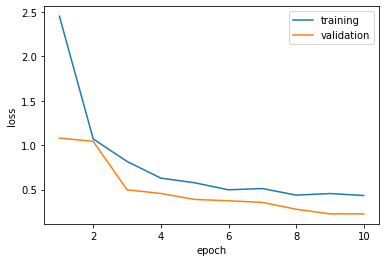

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Save the Model
Now that we have trained the model, we can save its weights. Then later, we can reload those weights into an instance of the same network and use it to predict classes from new images.

In [6]:
# Save the model weights
model_file = 'shape-classifier.pt'
torch.save(model.state_dict(), model_file)
print("Model saved.")

# Delete the existing model variable
del model

Model saved.


## Use the Model with New Data
Now that we've trained and evaluated our model, we can use it to predict classes for new images.

### Create Functions to Prepare Data and Get Class Predictions
Let's create a couple of functions to:

- Resize new images to match the size on which the model was trained.
- Submit the new images to the model and retrieve the predicted classes.

In [7]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['circle', 'square', 'triangle']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = image_tensor

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


### Predict Image Classes
Now we're ready to use the model for predicting (often referred to as *inferencing*) the classes of some new images.

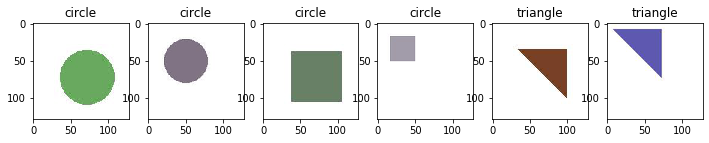

In [8]:
import os
from random import randint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model weights
model = Net()
model.load_state_dict(torch.load(model_file))


#get the list of test image files
test_folder = '../data/shapes/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
